# Additional examples

In [1]:
import ivim
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt

# Define output folder (can be any valid folder)
folder = os.path.join(tempfile.gettempdir(),'ivim_example')
if not os.path.exists(folder):
    os.mkdir(folder)

### Comparison of model fitting algorithms

Start by generating synthetic data

In [2]:
b = [0,10,20,30,40,50,75,100,200,400,600,800]
bval_file = os.path.join(folder,'example.bval')
ivim.io.base.write_bval(bval_file, b)

D = [0.8e-3, 1.0e-3]
f = [0.1, 0.15]
Dstar = [20e-3, 15e-3]
regime = ivim.models.DIFFUSIVE_REGIME

sz = [20,20,10]
pars = ['D','f','Dstar']
files_sim = {}
for par, vals in zip(pars, [D, f, Dstar]):
    im = vals[0] * np.ones(sz)
    im[sz[0]//4:3*sz[0]//4,sz[1]//4:3*sz[1]//4,:] = vals[1]
    files_sim[par] = os.path.join(folder, f'sim_{par}.nii.gz')
    ivim.io.base.write_im(files_sim[par], im)

noise_sigma = 1/40 # SNR = 40, given S0 = 1 as default
outbase_sim = os.path.join(folder,'ivim_sim')
ivim.sim.noise(files_sim['D'], files_sim['f'], regime, bval_file, noise_sigma, outbase_sim, Dstar_file = files_sim['Dstar'])
im_file = outbase_sim + '.nii.gz'

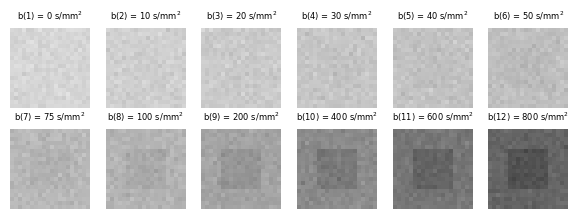

In [3]:
im = ivim.io.base.read_im(im_file)

fig,axes = plt.subplots(len(b)//6,6,figsize=(6*1.2,len(b)//6*1.2))
for i,ax in enumerate(axes.flatten()):
    ax.imshow(im[...,0,i], cmap='gray', vmin=0, vmax=1.2)
    ax.axis('off')
    ax.set_title(f'b({i+1}) = {int(b[i]):d} s/mm$^2$', fontsize = 6)

Apply model fitting algorithms

In [4]:
outbase_nlls = os.path.join(folder,'nlls')
ivim.fit.nlls(im_file, bval_file, regime, outbase=outbase_nlls)

outbase_seg = os.path.join(folder,'seg')
bthr = 200
ivim.fit.seg(im_file, bval_file, regime, bthr, outbase=outbase_seg)

outbase_bayes = os.path.join(folder,'bayes')
ivim.fit.bayes(im_file, bval_file, regime, outbase=outbase_bayes)

outbase_bayessp = os.path.join(folder,'bayes_sp')
mask_file = os.path.join(folder,'mask.nii.gz')
ivim.io.base.write_im(mask_file,np.ones(sz),imref_file=im_file)
ivim.fit.bayes(im_file, bval_file, regime, outbase=outbase_bayessp, spatial_prior=True, roi_file=mask_file)

/home/oscar/programming/ivim/ivim/fit.py:536: RuntimeWarning: overflow encountered in square
  ssq_new = np.sum((Y[mask, :] - fn(X, thetanew))**2, axis=1)
/home/oscar/programming/ivim/ivim/models.py:29: RuntimeWarning: overflow encountered in exp
  S = np.exp(-np.outer(D, b))
/home/oscar/programming/ivim/ivim/fit.py:539: RuntimeWarning: overflow encountered in divide
  post_ratio[nonzero] = ((ssq_new[nonzero] / ssq_old[nonzero])**(-X.shape[0]/2)


Display parameter maps

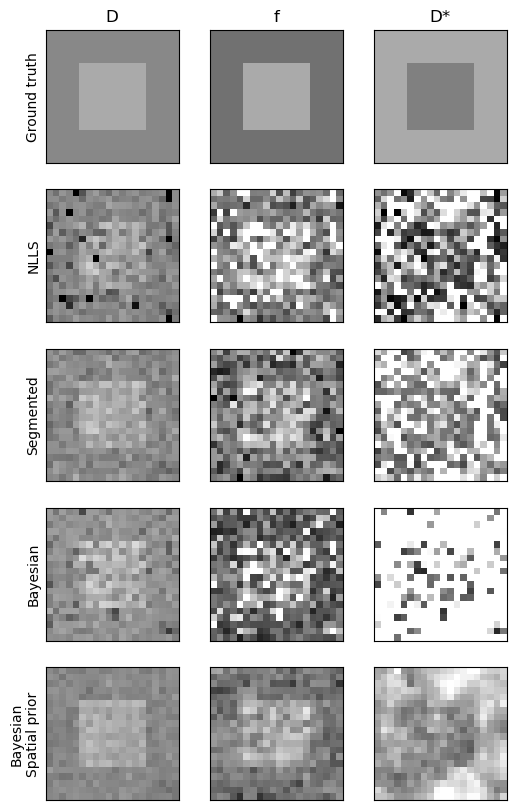

In [5]:
fig,axes = plt.subplots(5,3,figsize=(3*2,5*2))
for par,plotpar,axs in zip(pars,['D*' if par == 'Dstar' else par for par in pars],axes.T):
    maps = [ivim.io.base.read_im(files_sim[par])]
    for outbase in [outbase_nlls, outbase_seg, outbase_bayes, outbase_bayessp]:
        maps += [ivim.io.base.read_im(outbase+f'_{par}.nii.gz')]
    
    for im,ax in zip(maps,axs):
        ax.imshow(im[...,0], cmap='gray', vmin=0, vmax=1.5*np.max(maps[0]))
        ax.set_xticks([])
        ax.set_yticks([])
        if ax == axs[0]:
            ax.set_title(plotpar)
    if axs[0] is axes[0][0]:
        axs[0].set_ylabel('Ground truth')
        axs[1].set_ylabel('NLLS')
        axs[2].set_ylabel('Segmented')
        axs[3].set_ylabel('Bayesian')
        axs[4].set_ylabel('Bayesian\nSpatial prior')

Compare distribution of parameter estimates

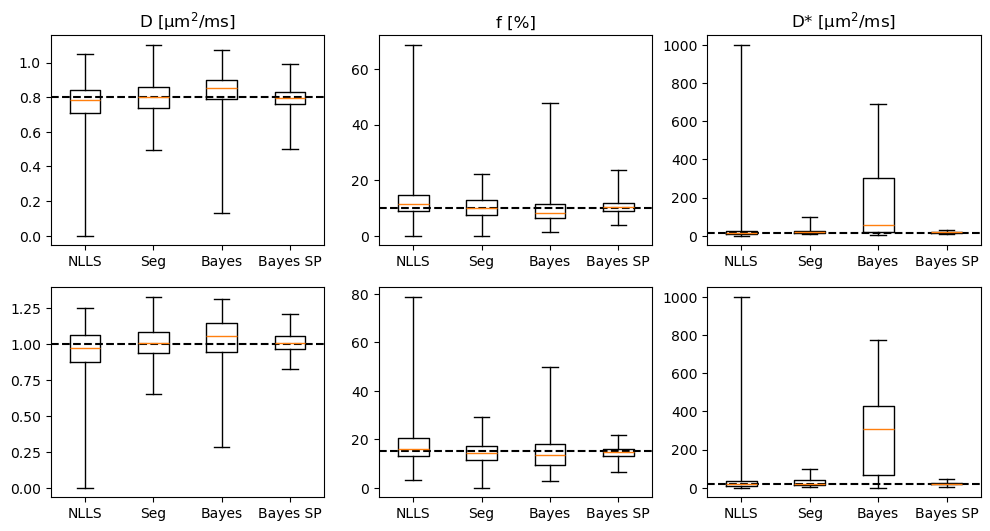

In [6]:
fig,axes = plt.subplots(2,3,figsize=(3*4,2*3))
for par,scale,unit,plotpar,axs in zip(pars,[1e3,1e2,1e3],[r'µm$^2$/ms','%',r'µm$^2$/ms'],['D*' if par == 'Dstar' else par for par in pars],axes.T):
    truemap = ivim.io.base.read_im(files_sim[par])
    maps = []
    for outbase in [outbase_nlls, outbase_seg, outbase_bayes, outbase_bayessp]:
        maps += [ivim.io.base.read_im(outbase+f'_{par}.nii.gz')]
    
    for par_val,ax in zip(np.unique(truemap),axs):
        data = [im[truemap==par_val]*scale for im in maps]
        ax.plot([0.5,len(data)+0.5],2*[par_val*scale],'--k')
        ax.boxplot(data,whis=np.inf,tick_labels=['NLLS','Seg','Bayes','Bayes SP'])
        if ax == axs[0]:
            ax.set_title(plotpar+' ['+unit+']')

The Bayesian algorithm with spatial priors has the overall best performance with low bias and high precision for all parameters.

### Langevin equation

Comparison of velocity autocorrelation function obtained from simulations and the theoretical one.

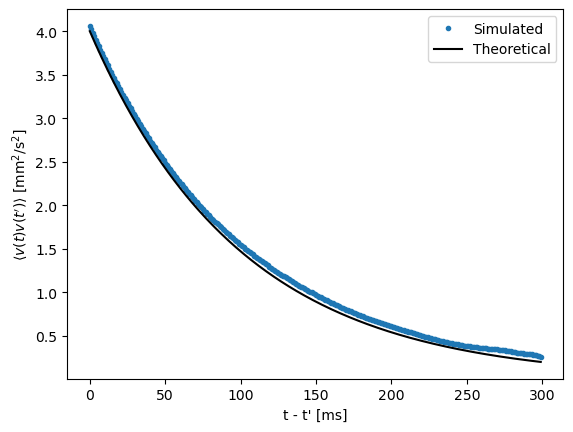

In [7]:
sigma_v = 2e-3
tau = 100e-3
dt = 1e-3
m = 300
n = 10000

v = ivim.sim.langevin(sigma_v,tau,dt,m,n)

vacf_sim = np.zeros((m,3))
vacf_sim[0,:] = np.mean(np.var(v,axis=0),axis=0)
for i in range(1,m):
    vacf_sim[i,:] = np.mean(np.mean(v[:,:-i,:]*v[:,i:,:],axis=0),axis=0)

t = np.arange(m)*dt
vacf_an = sigma_v**2 * np.exp(-t/tau)
plt.plot(t*1e3,vacf_sim[:,0]*1e6,'.',label='Simulated')
plt.plot(t*1e3,vacf_an*1e6,'k-',label='Theoretical')
plt.xlabel("t - t' [ms]")
plt.ylabel(r"$\langle v(t)v(t') \rangle$ [mm$^2$/s$^2$]")
plt.legend();


Trajectories in a 1x1x1 mm3 cube.

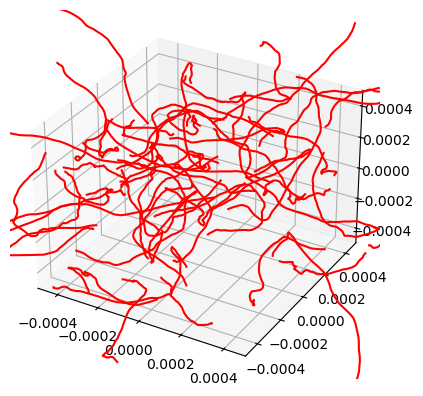

In [8]:
walkers = 50
r = 1e-3*(np.random.rand(walkers,3)-0.5)[:,np.newaxis,:] + np.cumsum(v[:walkers,:,:],axis=1)*dt

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
for i in range(walkers):
    ax.plot(r[i,:,0],r[i,:,1],r[i,:,2],'r')
ax.set_xlim([-0.5e-3,0.5e-3])
ax.set_ylim([-0.5e-3,0.5e-3])
ax.set_zlim([-0.5e-3,0.5e-3]);